In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import requests
import random

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm

print(f'Torch version: {torch.__version__}')
print(f'Torch vision version: {torchvision.__version__}')

Torch version: 2.5.1+cu121
Torch vision version: 0.20.1+cu121


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Get the data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

len(train_data), len(test_data)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.37MB/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 62.1MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.84MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(60000, 10000)

In [5]:
# Hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.01

In [6]:
X_sample = train_data[0]
len(X_sample)

2

In [7]:
img, label = X_sample
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [8]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
img.shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

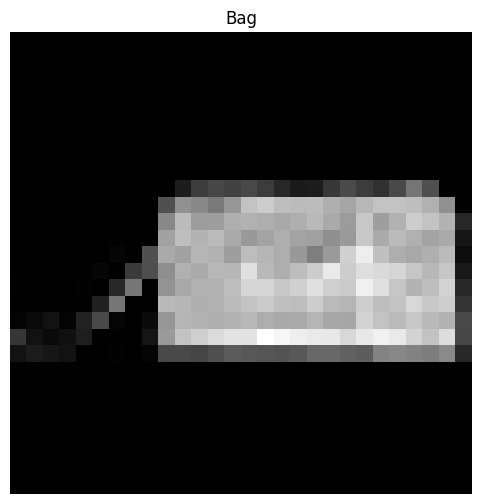

In [10]:
plt.figure(figsize=(10, 6))
random_idx = torch.randint(1, len(train_data), size=[1]).item()
img, label = train_data[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

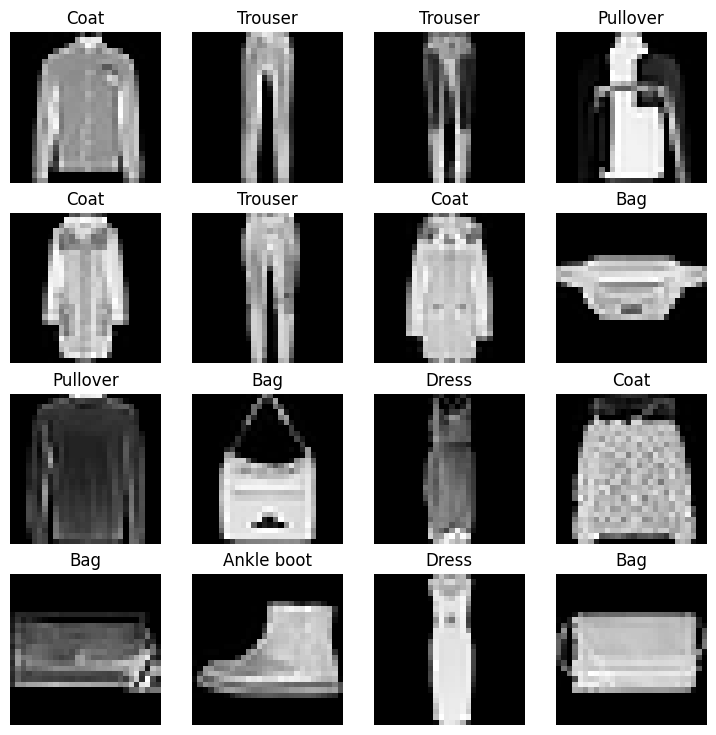

In [11]:
fig = plt.figure(figsize=(9, 9))
rows = cols = 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(1, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis(False)

In [12]:
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78384cdd1330>,
 <torch.utils.data.dataloader.DataLoader at 0x78385023d9c0>)

In [13]:
print(f'Train dataloader has a length of: {len(train_dataloader)} of {BATCH_SIZE} batchs')
print(f'Test dataloader has a length of: {len(test_dataloader)} of {BATCH_SIZE} batchs')

Train dataloader has a length of: 1875 of 32 batchs
Test dataloader has a length of: 313 of 32 batchs


In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [15]:
train_features_batch[0].shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

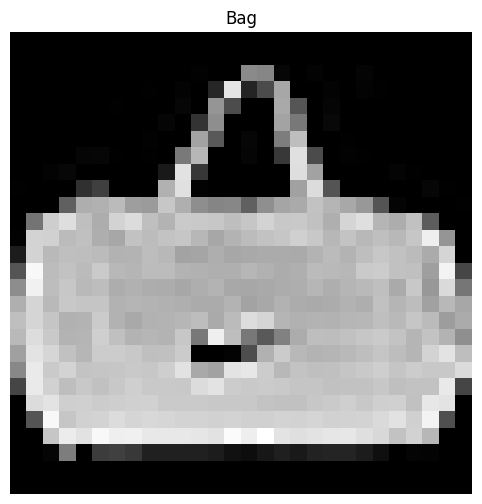

In [16]:
random_idx = torch.randint(1, len(train_features_batch), size=[1]).item()
img = train_features_batch[random_idx]
label = train_labels_batch[random_idx]
plt.figure(figsize=(10, 6))
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

In [17]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units//2),
            nn.Linear(in_features=hidden_units//2, out_features=hidden_units//4),
            nn.Linear(in_features=hidden_units//4, out_features=hidden_units//2),
            nn.Linear(in_features=hidden_units//2, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


model_0 = FashionMNISTModelV0(28*28, 32, len(class_names))
model_0

FashionMNISTModelV0(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=32, bias=True)
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

In [19]:
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists. Skipping download...')
else:
    request = requests.get('https://raw.githubusercontent.com/TheCloudOracle/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
    print('Done Downloading...')

from helper_functions import accuracy_fn as acc

Done Downloading...


In [20]:
def train(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device):
    model.to(device)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Send datasets to device
        X, y = X.to(device), y.to(device)    
        # Forward pass
        y_preds = model(X)
        # Calculate loss and accuracy
        t_loss = loss_fn(y_preds, y)
        train_loss += t_loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_preds.argmax(dim=1))
        # Optimizer zero grad
        optimizer.zero_grad()
        # Backpropagation
        t_loss.backward()
        # Optimizer step
        optimizer.step()
        if batch % 400 == 0:
            # Print what's going on
            print(f'Looked at: {len(X)*batch}/{len(dataloader.dataset)}')

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def test(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, accuracy_fn, device: torch.device):
    model.to(device)
    # Turn off gradient tracking
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for X, y in dataloader:
            # Set datasets to device
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_preds = model(X)
            # Calculate the loss and the accuracy
            test_loss += loss_fn(y_preds, y)
            test_acc += accuracy_fn(y_true=y, y_pred=y_preds.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc

def print_train_time(start: float, end: float, device: torch.device):
    total_time = end - start
    print(f'Trained for {total_time:.2f} second(s) on {device}')
    return total_time

def eval_model(model: nn.Module, dataloader: DataLoader, loss_fn, accuracy_fn, device: torch.device):
    model.eval()
    test_loss, test_acc = test(model, test_dataloader, loss_fn, acc, device)
    return {'model_name': model.__class__.__name__, 'test_loss': test_loss.item(), 'test_acc': test_acc}

In [21]:
epochs = 3
train_start_model_0 = timer()
for epoch in tqdm(range(epochs)):
    print(f'Epoch #{epoch+1}\n=====================')
    train_loss, train_acc = train(model_0, train_dataloader, criterion, optimizer, acc, 'cpu')
    test_loss, test_acc = test(model_0, test_dataloader, criterion, acc, 'cpu')
    print(f'Train Loss: {train_loss:.2f} Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.2f} Test Accuracy: {test_acc:.2f}%')
train_end_model_0 = timer()
model_0_time = print_train_time(start=train_start_model_0, end=train_end_model_0, device='cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #1
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 1.46 Train Accuracy: 42.21% | Test Loss: 0.92 Test Accuracy: 63.57%
Epoch #2
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 0.82 Train Accuracy: 69.17% | Test Loss: 0.73 Test Accuracy: 73.48%
Epoch #3
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 0.67 Train Accuracy: 75.40% | Test Loss: 0.69 Test Accuracy: 76.09%
Trained for 28.61 second(s) on cpu


In [22]:
model_0_results = eval_model(model_0, test_dataloader, criterion, acc, 'cpu')
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'test_loss': 0.6864315271377563,
 'test_acc': 76.08825878594249}

In [23]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units//2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units//2, out_features=hidden_units//4),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units//4, out_features=hidden_units//2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units//2, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


model_1 = FashionMNISTModelV1(28*28, 32, len(class_names))
model_1

FashionMNISTModelV1(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=8, bias=True)
    (6): ReLU()
    (7): Linear(in_features=8, out_features=16, bias=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=32, bias=True)
    (10): ReLU()
    (11): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)

In [25]:
epochs = 3
train_start_model_1 = timer()
for epoch in tqdm(range(epochs)):
    print(f'Epoch #{epoch+1}\n=====================')
    train_loss, train_acc = train(model_1, train_dataloader, criterion, optimizer, acc, 'cpu')
    test_loss, test_acc = test(model_1, test_dataloader, criterion, acc, 'cpu')
    print(f'Train Loss: {train_loss:.2f} Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.2f} Test Accuracy: {test_acc:.2f}%')
train_end_model_1 = timer()
model_1_time = print_train_time(start=train_start_model_1, end=train_end_model_1, device='cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #1
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 2.28 Train Accuracy: 16.61% | Test Loss: 2.17 Test Accuracy: 22.11%
Epoch #2
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 1.33 Train Accuracy: 47.25% | Test Loss: 0.89 Test Accuracy: 63.95%
Epoch #3
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 0.79 Train Accuracy: 68.63% | Test Loss: 0.70 Test Accuracy: 72.80%
Trained for 29.08 second(s) on cpu


In [26]:
model_1_results = eval_model(model_1, test_dataloader, criterion, acc, 'cpu')
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'test_loss': 0.7032787799835205,
 'test_acc': 72.8035143769968}

In [27]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*5*5, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=16, output_shape=len(class_names))
model_2


FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_featur

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=LEARNING_RATE)

In [29]:
epochs = 10
train_start_model_2 = timer()
for epoch in tqdm(range(epochs)):
    print(f'Epoch #{epoch+1}\n=====================')
    train_loss, train_acc = train(model_2, train_dataloader, criterion, optimizer, acc, device)
    test_loss, test_acc = test(model_2, test_dataloader, criterion, acc, device)
    print(f'Train Loss: {train_loss:.2f} Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.2f} Test Accuracy: {test_acc:.2f}%')
train_end_model_2 = timer()
model_2_time = print_train_time(start=train_start_model_2, end=train_end_model_2, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 2.30 Train Accuracy: 9.96% | Test Loss: 2.30 Test Accuracy: 9.98%
Epoch #2
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 2.30 Train Accuracy: 10.04% | Test Loss: 2.30 Test Accuracy: 8.71%
Epoch #3
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 2.30 Train Accuracy: 11.00% | Test Loss: 2.30 Test Accuracy: 14.59%
Epoch #4
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 1.56 Train Accuracy: 43.98% | Test Loss: 0.77 Test Accuracy: 72.07%
Epoch #5
Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
Train Loss: 0.63 Train Accuracy: 76.93% | Test Loss: 0.56 Test Accuracy: 79.26%
Epo

In [30]:
model_2_results = eval_model(model_2, test_dataloader, criterion, acc, device)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'test_loss': 0.37680497765541077,
 'test_acc': 85.99241214057508}

In [31]:
results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
results

,model_name,test_loss,test_acc
0,FashionMNISTModelV0,0.686432,76.088259
1,FashionMNISTModelV1,0.703279,72.803514
2,FashionMNISTModelV2,0.376805,85.992412


In [32]:
results['training_time'] = [
    model_0_time,
    model_1_time,
    model_2_time
]

results

,model_name,test_loss,test_acc,training_time
0,FashionMNISTModelV0,0.686432,76.088259,28.610493
1,FashionMNISTModelV1,0.703279,72.803514,29.082411
2,FashionMNISTModelV2,0.376805,85.992412,123.391850


Text(0, 0.5, 'Model')

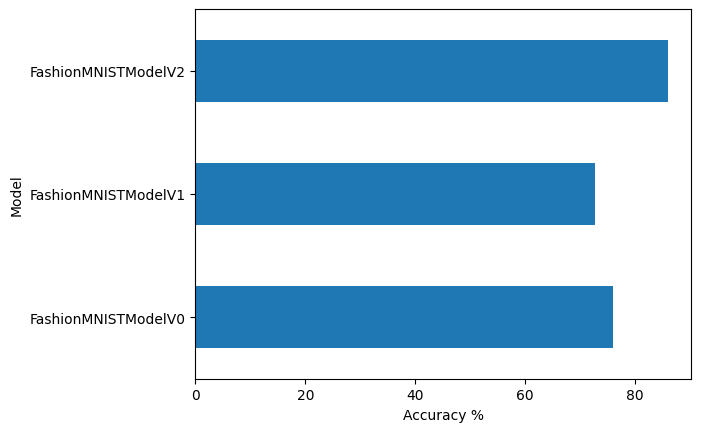

In [33]:
results.set_index('model_name')['test_acc'].plot(kind='barh')
plt.xlabel('Accuracy %')
plt.ylabel('Model')

In [34]:
def make_predictions(model: nn.Module, data: list, device: torch.device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs)

In [35]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f'Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} {class_names[test_labels[0]]}')

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 1 Trouser


In [36]:
pred_probs = make_predictions(model_2, test_samples, device)
pred_probs[:2]

tensor([[5.8456e-05, 9.9987e-01, 2.1176e-06, 7.2729e-06, 5.1414e-05, 2.6935e-08,
         8.0661e-06, 9.2823e-08, 4.1772e-08, 4.2463e-08],
        [1.1772e-07, 9.3550e-07, 3.0260e-08, 3.3570e-07, 8.0263e-08, 1.1983e-03,
         2.7380e-07, 2.2207e-03, 1.1538e-05, 9.9657e-01]], device='cuda:0')

In [37]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 9, 0, 0, 9, 4, 6, 0, 9], device='cuda:0')

In [38]:
test_labels, pred_classes

([1, 9, 0, 0, 9, 6, 4, 0, 9],
 tensor([1, 9, 0, 0, 9, 4, 6, 0, 9], device='cuda:0'))

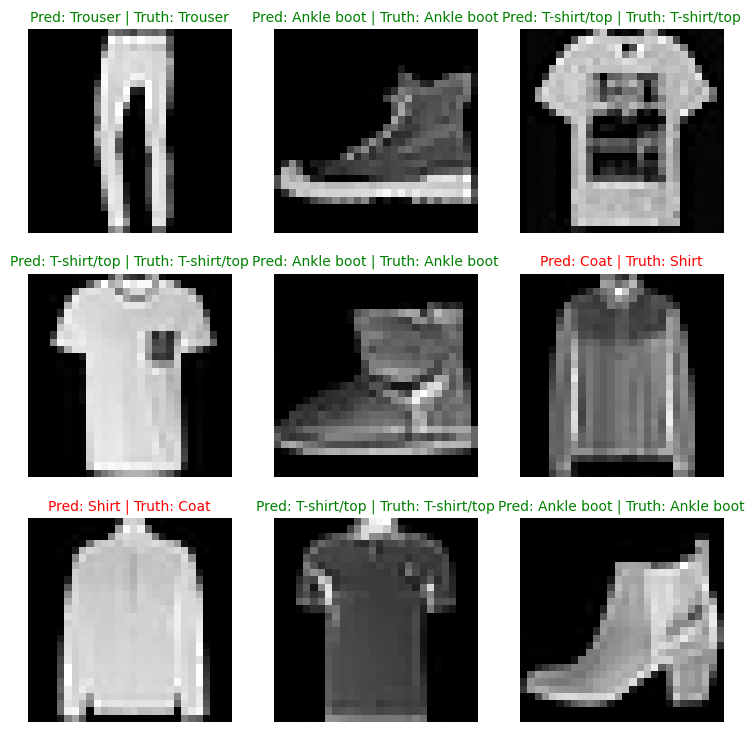

In [39]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);